In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.5916157281026244e-12


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = scale_variables.Shape_timesteps()
trainX_jets, trainX_other = timestep_builder.reshape_X(trainX, X_names, False)
testX_jets, testX_other = timestep_builder.reshape_X(testX, X_names, False)
# mask = timestep_builder.create_mask()

# Save some memory 
del trainX
del testX 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 6) (80000, 7) (80000, 12)
(20000, 6, 6) (20000, 7) (20000, 12)


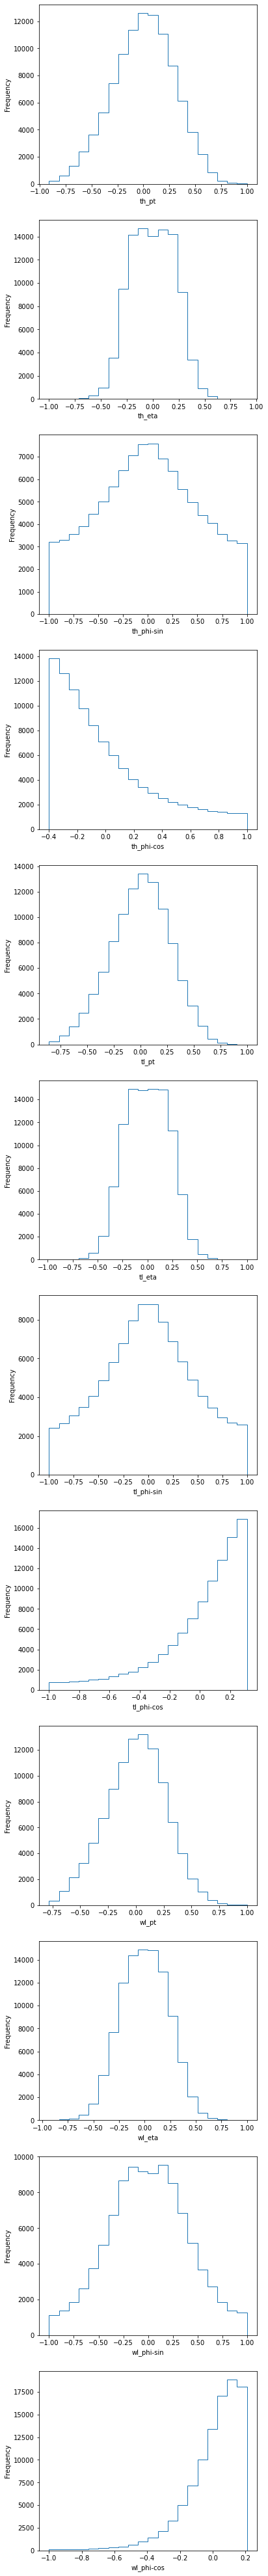

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*Y_total.shape[1]))
    for i in range(0, Y_total.shape[1]):
        plt.subplot(Y_total.shape[1], 1, i+1)
        plt.hist(Y_total[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables 
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Conv11 = Conv1D(filters=32, kernel_size=1, activation='relu', kernel_initializer=initializers.he_uniform())(jet_input)
    flat_jets = Flatten()(Conv11)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(32, activation='relu')(other_input)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-6)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           256         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6, 32)        224         input_1[0][0]                    
______________________________________________________________________________________________

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 2048

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/2048
64000/64000 [==============================] - 3s 44us/sample - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1473 - val_mse: 0.1473
Epoch 2/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1419 - mse: 0.1419 - val_loss: 0.1356 - val_mse: 0.1356
Epoch 3/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1323 - mse: 0.1323 - val_loss: 0.1277 - val_mse: 0.1277
Epoch 4/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1257 - mse: 0.1257 - val_loss: 0.1219 - val_mse: 0.1219
Epoch 5/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1207 - mse: 0.1207 - val_loss: 0.1176 - val_mse: 0.1176
Epoch 6/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1142 - val_mse: 0.1142
Epoch 7/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.1138 - mse: 0.1138 - val_

Epoch 59/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0697 - mse: 0.0697 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 60/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0688 - val_mse: 0.0688
Epoch 61/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 62/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0689 - mse: 0.0689 - val_loss: 0.0683 - val_mse: 0.0683
Epoch 63/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 64/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0678 - val_mse: 0.0678
Epoch 65/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0682 - mse: 0.0682 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 66/2048

Epoch 117/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0610 - mse: 0.0610 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 118/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0609 - mse: 0.0609 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 119/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 120/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0603 - val_mse: 0.0603
Epoch 121/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 122/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 123/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 

Epoch 175/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 176/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 177/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 178/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 179/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 180/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 181/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0570 - val_mse: 0.0570
Epoch 

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 233/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 234/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 235/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 236/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 237/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 238/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0552 - val_mse: 0.0552
Epoch 239/2048
64000/

Epoch 290/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 291/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 292/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 293/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 294/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 295/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 296/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 

Epoch 348/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 349/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 350/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 351/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 352/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 353/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 354/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 

Epoch 406/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 407/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 408/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 409/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 410/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 411/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 412/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 

Epoch 464/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 465/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 466/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 467/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 468/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 469/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 470/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 

Epoch 522/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 523/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 524/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 525/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 526/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 527/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 528/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 

Epoch 580/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 581/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 582/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 583/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 584/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 585/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 586/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 

Epoch 638/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 639/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 640/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 641/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 642/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 643/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 644/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 

Epoch 696/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 697/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 698/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 699/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 700/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 701/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 702/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 

Epoch 754/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 755/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 756/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 757/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 758/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 759/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 760/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 

Epoch 812/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 813/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 814/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 815/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 816/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 817/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 818/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 

Epoch 870/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 871/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 872/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 873/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 874/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 875/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 876/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 

Epoch 928/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 929/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 930/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 931/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 932/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 933/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 934/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 986/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 987/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 988/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 989/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 990/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 991/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 992/2048
64000/

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1043/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1044/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1045/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1046/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1047/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1048/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1049/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 1100/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1101/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1102/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1103/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1104/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1105/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1106/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1157/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1158/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1159/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1160/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1161/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1162/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 1163/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1214/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1215/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1216/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1217/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1218/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1219/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 1220/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1271/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1272/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1273/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1274/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1275/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1276/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1277/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1328/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1329/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1330/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1331/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1332/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1333/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1334/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1385/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1386/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1387/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1388/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1389/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1390/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1391/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1442/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1443/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1444/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1445/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1446/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1447/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1448/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1499/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1500/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1501/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1502/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1503/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1504/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1505/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1556/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1557/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1558/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1559/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1560/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1561/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1562/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1613/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1614/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1615/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1616/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1617/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1618/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1619/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1670/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1671/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1672/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1673/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1674/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1675/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1676/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1727/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1728/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1729/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1730/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1731/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1732/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1733/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1784/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1785/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1786/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1787/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1788/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1789/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1790/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1841/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1842/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1843/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1844/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1845/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1846/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1847/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1898/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1899/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1900/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1901/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1902/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1903/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1904/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1955/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1956/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1957/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1958/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1959/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1960/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 1961/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2012/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2013/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2014/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2015/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2016/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2017/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2018/2048

Text(0.5, 1.0, 'MSE loss')

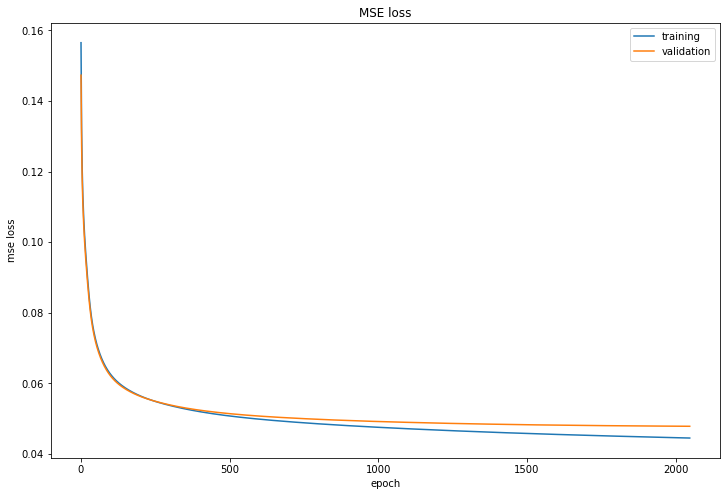

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [9]:
predictions = model.predict([testX_jets, testX_other])

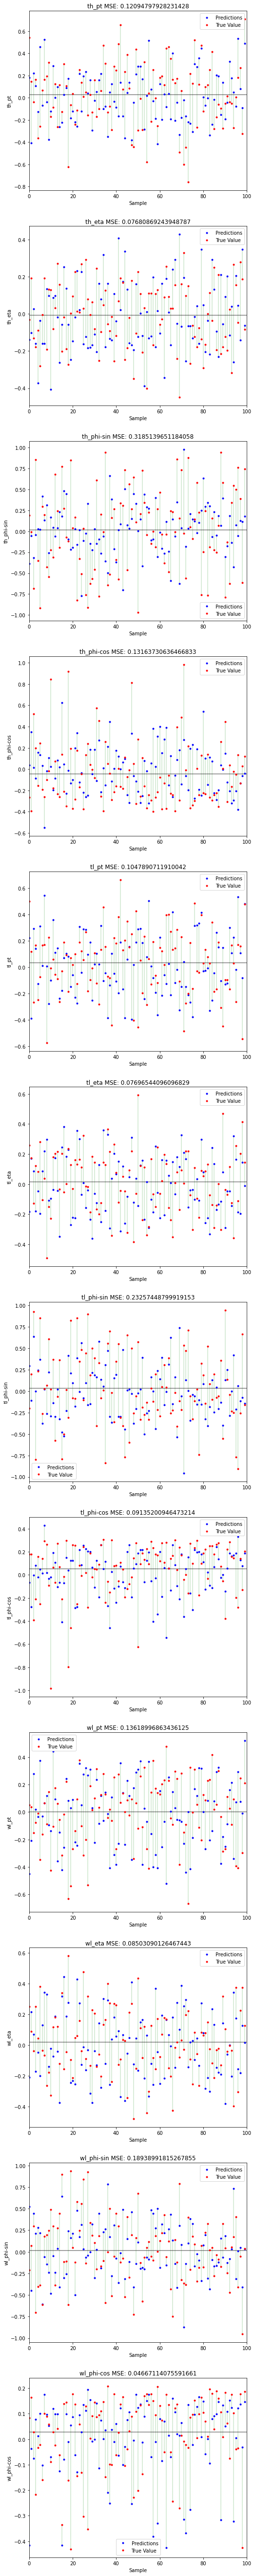

In [10]:

# Training 
crop = 100 

train_small = predictions[0:100,:]
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*len(Y_names)))
    for i in range(0,len(Y_names)):
        plt.subplot(len(Y_names),1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [11]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.047994345122980536
th_pt MSE :  0.0348774180
th_eta MSE :  0.0125857567
th_phi-sin MSE :  0.1629591001
th_phi-cos MSE :  0.0709751528
tl_pt MSE :  0.0265744464
tl_eta MSE :  0.0100431221
tl_phi-sin MSE :  0.1212467722
tl_phi-cos MSE :  0.0423798974
wl_pt MSE :  0.0160909249


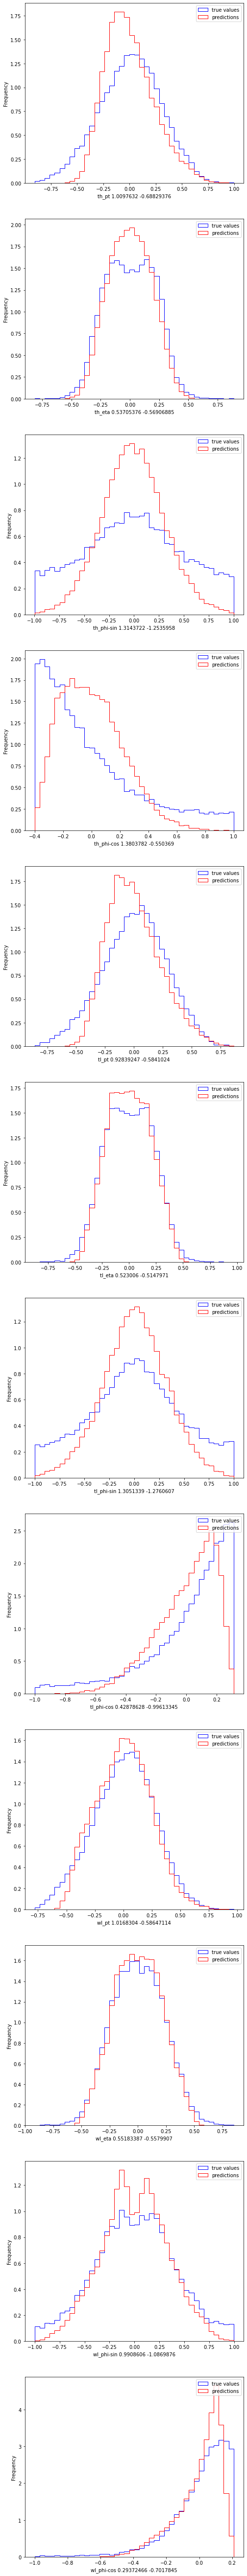

In [12]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

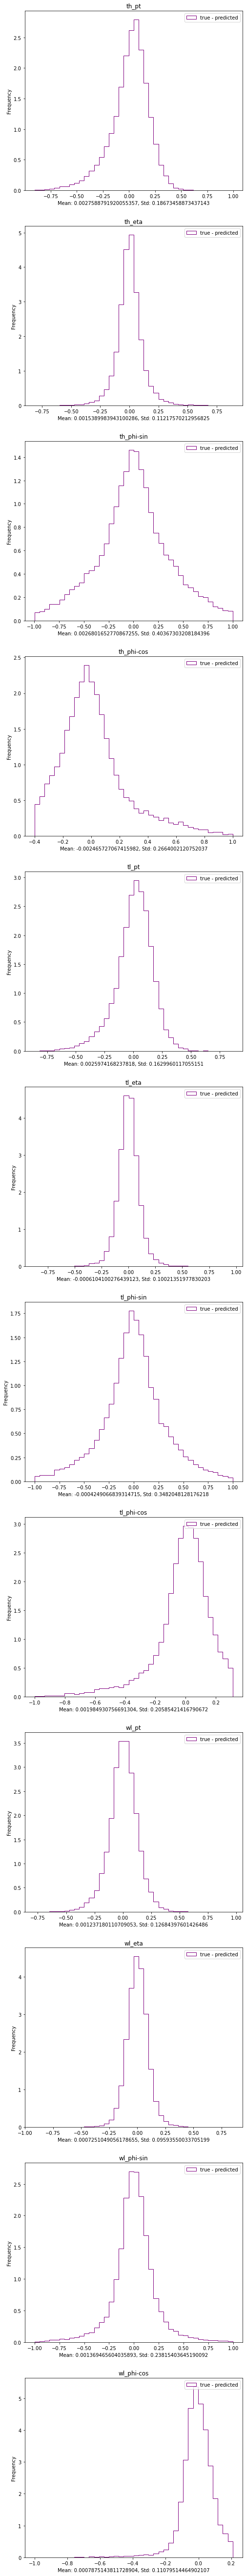

In [13]:
# True - Predicted 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [14]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

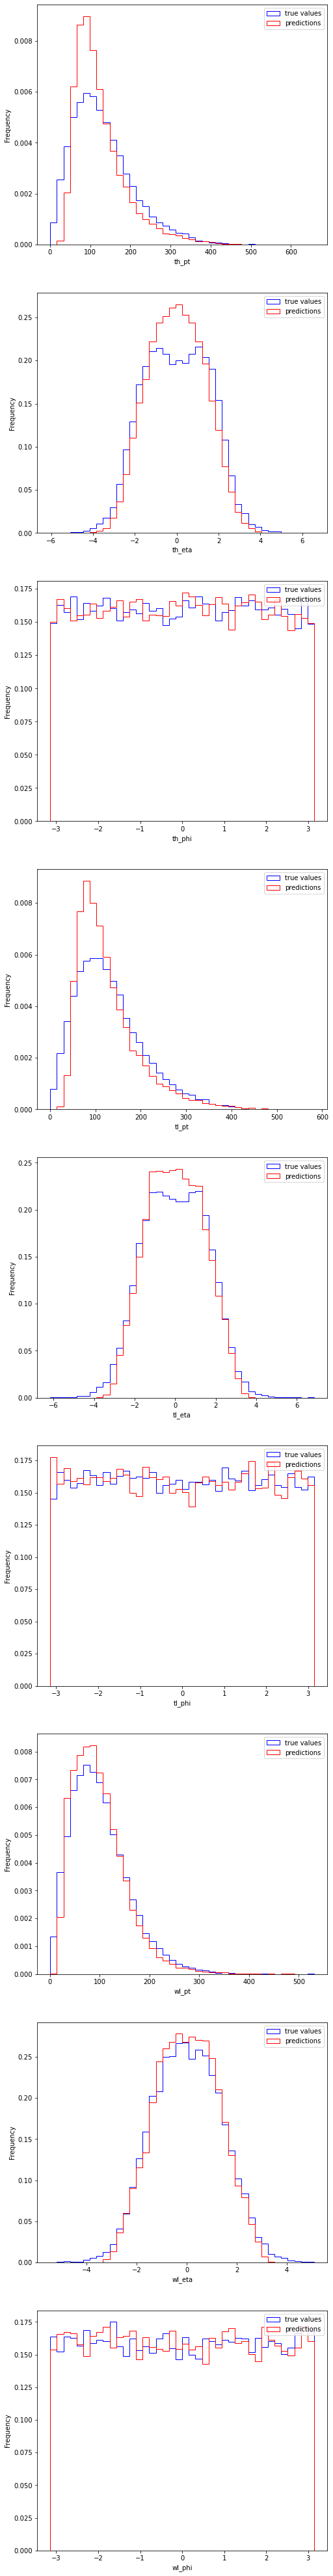

In [15]:
# Histograms to the original scale 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

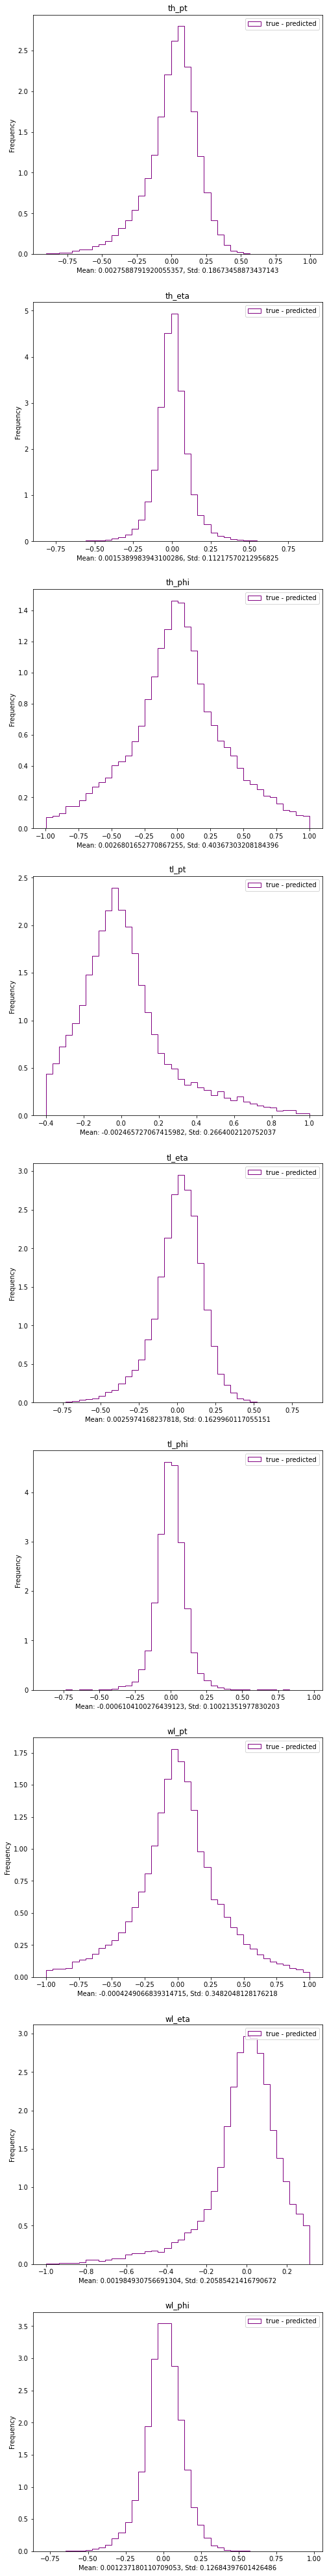

In [16]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

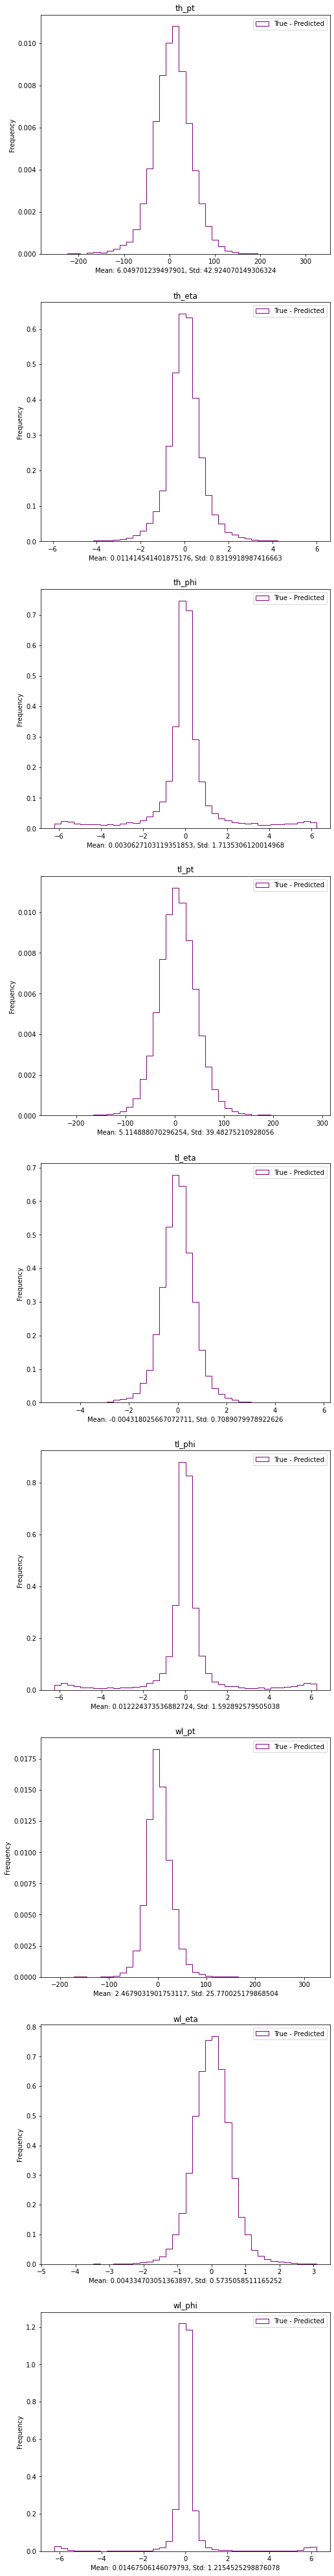

In [17]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [18]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1879.0746832698
Original Scale th_eta MSE :  0.6923408113
Original Scale th_phi MSE :  0.8682405248
Original Scale tl_pt MSE :  1585.0497940946
Original Scale tl_eta MSE :  0.5025691948
Original Scale tl_phi MSE :  0.5649429285
Original Scale wl_pt MSE :  670.1847439271
Original Scale wl_eta MSE :  0.3289277509
Original Scale wl_phi MSE :  0.1986458070


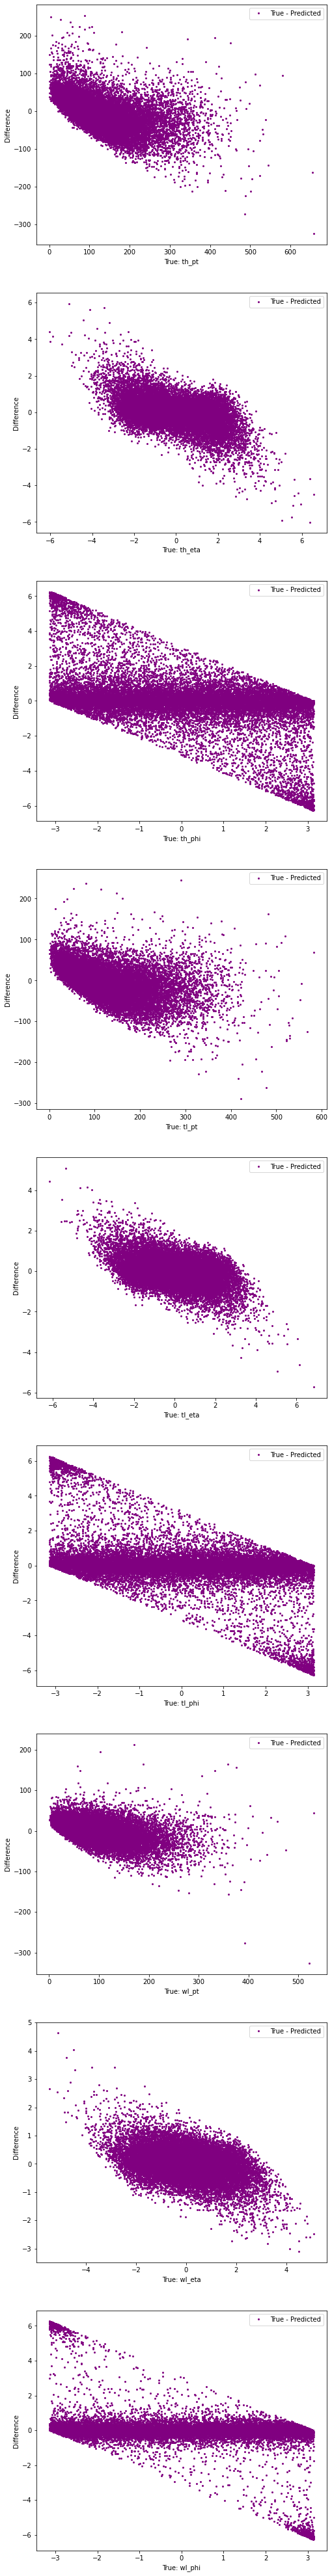

In [19]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')